In [1]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl, seaborn.apionly as sns
import pcmdpy as ppy
from scipy.stats import lognorm
%matplotlib inline

GPU acceleration enabled


In [2]:
ppy.gpu_utils.initialize_gpu(n=0)

using given n: 0
Starting SourceModule Code
Getting function
Past the SourceModule code
CUDAC Available


In [3]:
f = ppy.instrument.m31_filters()
iso_model = ppy.isochrones.Isochrone_Model(f)
driv = ppy.driver.Driver(iso_model, gpu=True)

In [4]:
mu = [-2., -1., 0., 1., 3.]
sig = [0.1, 1., 10.]

In [5]:
gm = ppy.galaxy.CustomGalaxy(ppy.metalmodels.SingleFeH, ppy.dustmodels.LogNormDust, ppy.agemodels.SSPModel)
gals = np.array([[gm.get_model(np.array([0., a, b, 5., 10])) for b in sig] for a in mu])

In [6]:
for g in gals.flatten():
    print(g.dust_model.get_params())

(0.5, -4.605170185988092, 0.1)
(0.5, -4.605170185988092, 1.0)
(0.5, -4.605170185988092, 10.0)
(0.5, -2.302585092994046, 0.1)
(0.5, -2.302585092994046, 1.0)
(0.5, -2.302585092994046, 10.0)
(0.5, 0.0, 0.1)
(0.5, 0.0, 1.0)
(0.5, 0.0, 10.0)
(0.5, 2.302585092994046, 0.1)
(0.5, 2.302585092994046, 1.0)
(0.5, 2.302585092994046, 10.0)
(0.5, 6.907755278982138, 0.1)
(0.5, 6.907755278982138, 1.0)
(0.5, 6.907755278982138, 10.0)


In [7]:
nr = len(mu)
nc = len(sig)

In [14]:
pcmds = np.array([[driv.simulate(gals[i][j], 512, psf=True, fixed_seed=False)[0] for j in range(nc)] for i in range(nr)])

In [17]:
np.isnan(pcmds).sum()

0

In [18]:
colors = pcmds[:,:,1,:]
mags = pcmds[:,:,0,:]
bins = [np.linspace(colors.min(), colors.max(), 100), np.linspace(mags.min(), mags.max(), 100)]

In [19]:
np.vstack(pcmds).shape

(15, 2, 262144)

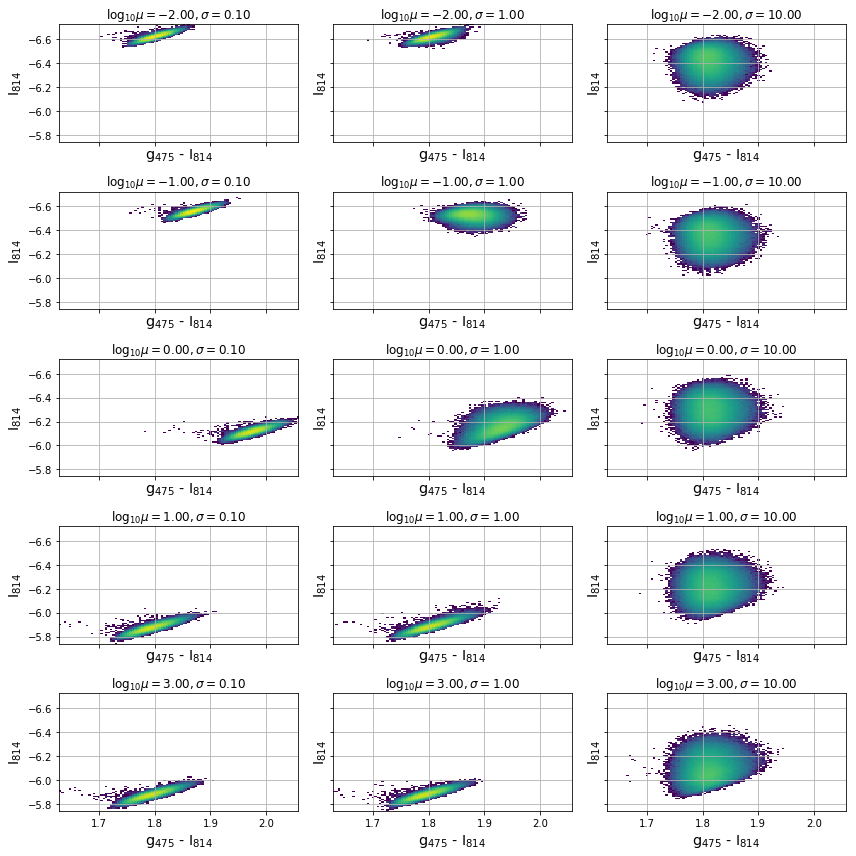

In [26]:
fig, axes = plt.subplots(ncols=nc, nrows=nr, figsize=(12, 12), sharex=True, sharey=True)
n = mpl.colors.LogNorm()
for ax, g, pcmd in zip(axes.flatten(), gals.flatten(), np.vstack(pcmds)):
    plt.subplot(ax)
    if np.any(np.isnan(pcmd)):
        continue
    plt.hist2d(pcmd[1], pcmd[0], bins=bins, norm=n)
    _, m, s = g.dust_model.get_params()
    ax.set_title(r'$\log_{10}\mu = $' + r'${:.2f}, \sigma = {:.2f}$'.format(m / np.log(10.), s))
for a in axes.flatten(): 
    a.grid(True)
    iso_model.plot_isochrone(gals[0][0], axes=a)
plt.tight_layout()
# plt.colorbar(ax=axes)

In [81]:
import pycuda
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
from pycuda import curandom
from pycuda import cumath

In [94]:
_other_code = """
#include <curand_kernel.h>
#include <math.h>
extern "C"
{
__global__ void test(curandState *global_state, const float red_per_ebv, const float dust_mean, const float dust_std, const int N, float *results)
{
    int id_imx = blockIdx.x*blockDim.x + threadIdx.x;
    float ebv, reddening;
    curandState local_state = global_state[id_imx];
    
    if (id_imx < N) {
        ebv = curand_log_normal(&local_state, dust_mean, dust_std);
        reddening = pow(10., -0.4 * ebv * red_per_ebv);
        results[id_imx] = ebv * red_per_ebv;
    }
    global_state[id_imx] = local_state;
}
}
"""

In [95]:
_mod = SourceModule(_other_code, keep=False, no_extern_c=True)
_func = _mod.get_function('test')

/n/home01/bcook/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(9): warning: variable "reddening" was set but never used

kernel.cu(9): warning: variable "reddening" was set but never used


  """Entry point for launching an IPython kernel.


In [96]:
N = 2**13
print(N)

8192


In [97]:
generator = curandom.XORWOWRandomNumberGenerator(seed_getter=curandom.seed_getter_unique)

In [98]:
block_dim = (int(32), 1, 1)
grid_dim = (int(N//32 + 1), 1)
results = np.zeros((N), dtype=np.float32)
results_blah = np.zeros((N), dtype=np.float32)

In [101]:
mu, sig = 2., 1.
print(mu)
_func(generator.state, np.float32(f[0].red_per_ebv), np.float32(mu), np.float32(sig), np.int32(N),
      cuda.Out(results_blah), block=block_dim, grid=grid_dim)
_func(generator.state, np.float32(f[0].red_per_ebv), np.float32(mu), np.float32(sig), np.int32(N),
      cuda.Out(results), block=block_dim, grid=grid_dim)

results2 = f[0].red_per_ebv * np.random.lognormal(mean=mu, sigma=sig, size=N).astype(np.float32)

r = np.append(results, results2)
bins = np.linspace(r.min(), r.max(), 100)

2.0


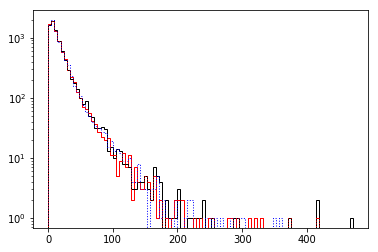

In [103]:
plt.hist(results, histtype='step', bins=bins, color='r')
plt.hist(results2, histtype='step', bins=bins, color='k')
plt.hist(results_blah, histtype='step', bins=bins, color='b', ls=':')
plt.hist(results_old, histtype='step', bins=bins, color='r', ls=':')
plt.yscale('log')

results_old = np.copy(results)